<a id='Q0'></a>
<center> <h1> Crypto Project - Bitcoin Price Machine Learning Experiment </h1> </center>
<center> <h2 class="blue-text" style="color: blue"> Time Series Machine Learning Model Evaluation </h2> </center>
<center> <h3 class="red-text" style="color: red"> BOOSTED DATASET </h3> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>ZHAW CAS DAENG Group 4, 09 July 2021</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="border-top:0.01cm solid #53c653;border-bottom:0.01cm solid #53c653;color:#303030">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm">
        <p> <strong> Outline:</strong>
        <a id="P0" name="P0"></a>
        <ol>
            <li> <a href='#I'>Import Libraries & Setup Project Directory</a> </li>
            <li> <a href='#R'>Read & look at the data</a></li>
            <li> <a href='#F'>Feature Selection</a></li>
            <li> <a href='#T'>Train, Test Split & Preprocessing</a></li>
            <li> <a href='#M'>Initial model testing</a></li>
            <li> <a href='#C'>Cross validation</a></li>
            <li> <a href='#H'>Hyperparameter-tuning</a></li>
            <li> <a href='#S'>Model Selection & Performance Comparison</a></li>
            <li> <a href='#P'>Prediction and Testing</a></li>
            <li> <a href='#X'>Comparison of Model Performance</a></li>
        </ol>
    </div>
</div>

<a id='I'></a>
## <font color='darkblue'>__Import Libraries__</font>

In [1]:
# Auto ML libraries
import comet_ml
comet_ml.init()
from comet_ml import Experiment
from lime.lime_tabular import LimeTabularExplainer
import shap
from pycaret.regression import *

COMET INFO: Comet API key is valid


In [2]:
# General libraries
import os
import pathlib
import time
import warnings
import dill
warnings.filterwarnings("ignore")

In [3]:
# External data
import yfinance as yf
from ta.trend import adx, macd

In [4]:
# Data manipulation and statistical libraries
import numpy as np
import pandas as pd
from math import ceil
from scipy import stats
from scipy.stats import f_oneway
from mlxtend.evaluate import paired_ttest_5x2cv
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.compat import lzip

In [5]:
# Data visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Defining Plot Styling
sns.set_style("darkgrid")
sns.despine()
plt.rc('lines', linewidth=2, color='b')
plt.rc('font', family='sans-serif')
plt.rc('font', size=10)
plt.rc('axes', titlelocation='center')
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize='large')
plt.rc('axes', labelcolor='blue')
plt.rc('figure', titlesize='large')
plt.rc('figure.subplot', hspace='0.6')
plt.rc('figure', figsize=(16,6))
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

<Figure size 432x288 with 0 Axes>

In [7]:
# Sckit-Learn processing libraries
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, 
                                     RepeatedKFold, RepeatedStratifiedKFold, GroupShuffleSplit, cross_validate)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    max_error,
    explained_variance_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_curve,
    plot_roc_curve,
    plot_precision_recall_curve,
    f1_score,
    r2_score,
    roc_auc_score
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from tscv import GapRollForward

In [8]:
# Sckit-learn model libraries
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, BayesianRidge, Lasso, LassoLars, ElasticNet, TweedieRegressor, PassiveAggressiveRegressor, SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [9]:
def adjusted_r2_score(y_true, y_pred, X_test):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true) - X_test.shape[1]-1)
    return adjusted_r2

In [10]:
# Setup the project directory
workdir = pathlib.Path().absolute()
project_dir = workdir.parent
data_path = f"{project_dir}\\00_Data\\"
print(data_path)

C:\Users\akosr\CAS_DAENG\Modul_02\crypto_project_ML\00_Data\


<a id='R'></a>
## <font color='darkblue'>__Read Data__</font>

In [11]:
# Read the Lagged Dataset
df_BTC_boosted = pd.read_csv(data_path+'bitcoin_boosted_dataset.csv')
df_BTC_boosted.set_index('Date', inplace=True)

In [12]:
df_BTC_boosted.head()

,WeightedPrice_return,DASH_return,DOGE_return,ETC_return,ETH_return,LTC_return,SC_return,XEM_return,XMR_return,XRP_return,ZEC_return,CLF_return,CNYUSDX_return,DJI_return,EURUSDX_return,GCF_return,GSPC_return,IXIC_return,JPYUSDX_return,TSLA_return,VIX_return,XWDTO_return,Volume,SMA_30,EMA_40,Altcoin_EMA_40,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8,SMA_05,SMA_90,EMA_05,EMA_90,MACD,Avg_Dir_Mvmt,RSI,Awesome_Osc,ROC,Stoch_RSI,Ultimate_Osc,True_SI,Cum_Return,Log_Return,Number_of_Transactions,Active_Addresses,New_Addresses,Hash_Rate,sentiment_elon,sentiment_bitcoin,time,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_relative,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,alt_rank_hour_average,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,social_contributors,price_btc,market_cap_global,market_dominance,percent_change_24h,social_volume,social_volume_global,social_dominance,Year,Quarter,Month (number),Day of year,Day of week (number),AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_volume,AMZN_close,AMZN_high,AMZN_low,AMZN_open,AMZN_volume,MSFT_close,MSFT_high,MSFT_low,MSFT_open,MSFT_volume,NASDX_close,NASDX_high,NASDX_low,NASDX_open,NASDX_volume,TSLA_close,TSLA_high,TSLA_low,TSLA_open,TSLA_volume,DAX_close,DAX_high,DAX_low,DAX_open,DAX_volume,Active Addresses,New Addresses,Number of Transactions,Zero Balance Addresses
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-29,-0.010854,0.001603,-0.010854,0.030326,0.014907,0.006114,-0.057956,-0.006438,-0.002725,0.003858,-0.016201,-0.004838,-0.000311,-0.000711,0.001343,-0.002013,-0.000832,-0.005902,-0.002111,-0.035061,0.006865,0.002254,17291.745458,8323.799541,8710.410980,23.340787,51.655920,2315.436090,-0.031827,9182.496796,9593.059924,9126.438352,9077.680536,121.892581,40.022822,62.435327,887.020833,18.521203,0.912613,48.323258,7.503944,1031.713136,2.228196,307953,745317,376839,94180744.35,positive,positive,1.572307e+09,9345.923327,9414.128198,9483.835174,9255.202323,2.030838e+10,1.695013e+11,23480.0,16239.0,371.0,11328.0,1491.0,7583.0,39964.0,5396.0,169112201.0,918.0,68398.0,4827.0,41715.0,4.0,1213.0,8211.0,29705.0,831.0,22341.0,5807595.0,27480608.0,133351002.0,2566513.0,169268595.0,3.8,96.0,43.0,3.0,4.0,3.4,70.5,0.011129,28.0,1.0,55.21,1.0,565.0,2.0,1.0,1.0,19357.0,1.0,2.529138e+11,67.019406,2.147217,58108.0,146467.0,39.673100,2019.0,4.0,10.0,302.0,3.0,243.290000,249.750000,242.570000,248.970000,3.570987e+07,1762.710000,1777.000000,1755.810000,1774.810000,2.276855e+06,142.830000,144.50,142.650000,144.080000,2.058947e+07,19.610000,19.610000,19.610000,19.610000,0.0,316.220000,324.300000,314.750000,319.990000,12684300.0,27.260000,27.260000,27.100000,27.100000,1807.000000,745317.0,376839.0,307953.0,452188.0
2019-10-30,-0.020376,-0.015189,-0.055363,-0.030303,-0.010662,-0.014041,0.028605,-0.031261,-0.033812,-0.012740,-0.014718,-0.008642,0.000283,0.004256,0.001412,0.004169,0.003253,0.003278,0.000827,-0.003826,-0.065909,0.008432,15126.281717,8360.255856,8733.185969,23.340977,49.898357,2344.500000,-0.028898,9373.300348,9582.328894,9143.391656,9079.869936,151.327943,39.554933,58.137644,1079.436262,11.481685,0.792149,50.135926,9.216121,1001.345454,-2.719996,314163,745381,385367,91293152.10,positive,positive,1.572394e+09,9307.104758,9161.485685,9307.104758,9065.189135,1.721086e+10,1.643719e+11,21938.0,16321.0,410.0,10204.0,1440.0,6651.0,37858.0,5630.0,151745470.0,597.0,43

In [13]:
df_BTC_boosted.shape

(2654, 143)

<a id='F'></a>
## <font color='darkblue'>__Feature Selection__</font>

### Boosted Dataset

### Correlations

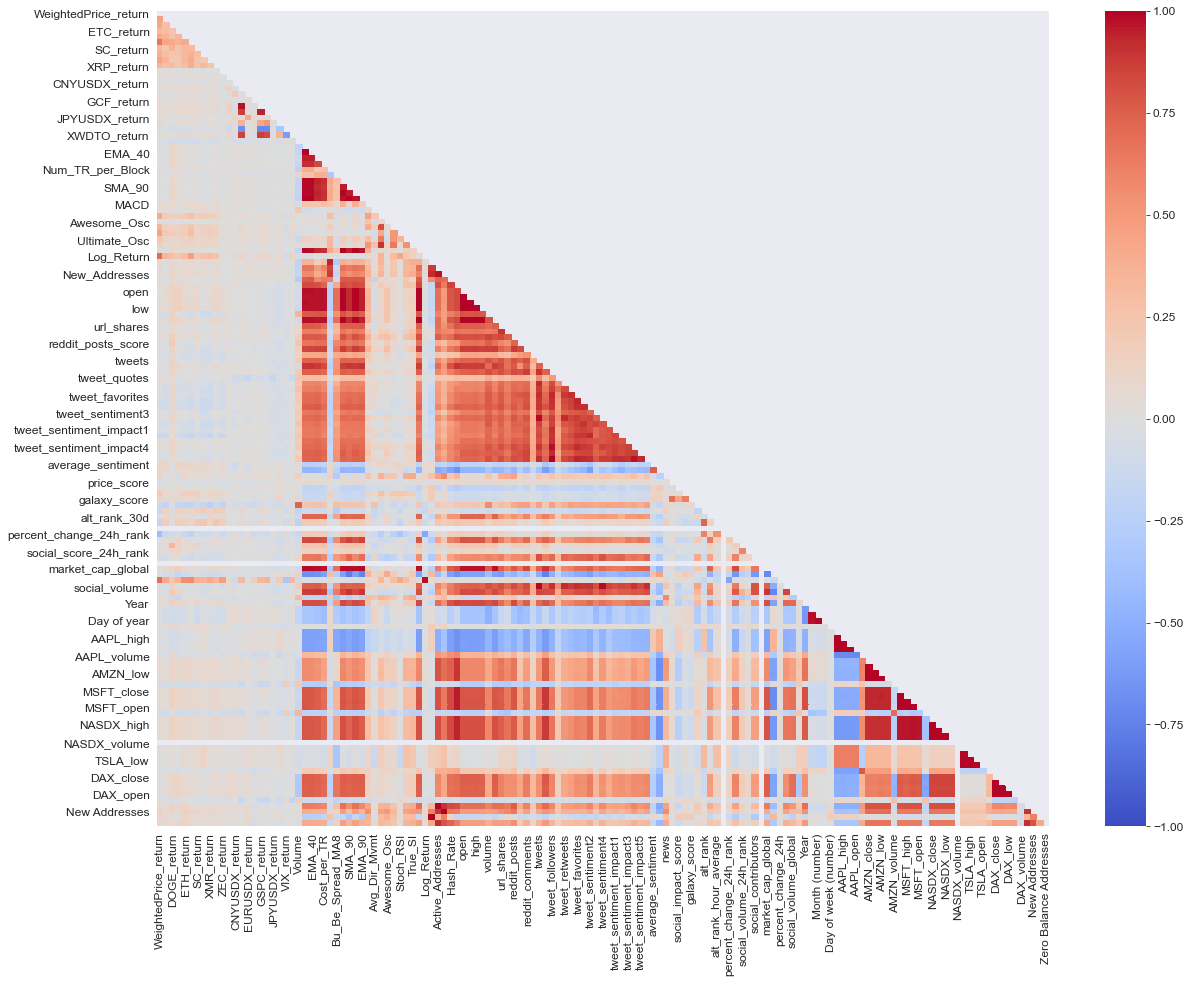

In [14]:
# Pearson Correlation Heatmap

corrmat_heat_lags = df_BTC_boosted.corr()
fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(corrmat_heat_lags)
_ax = sns.heatmap(corrmat_heat_lags, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

### Selecting Features - considering Multicollinearity

In [15]:
cat_feat = df_BTC_boosted.select_dtypes(include='object').columns.tolist()

In [16]:
cat_feat

['sentiment_elon', 'sentiment_bitcoin']

In [17]:
df_corr_lags = df_BTC_boosted.drop(columns=['sentiment_elon', 'sentiment_bitcoin', 'WeightedPrice_return'])

In [18]:
corrmat_features_lags = df_corr_lags.corr()

In [19]:
columns_lags = np.full((corrmat_features_lags.shape[0], ), True, dtype=bool)

In [20]:
for i in range(corrmat_features_lags.shape[0]):
    for j in range(i+1, corrmat_features_lags.shape[0]):
        if abs(corrmat_features_lags.iloc[i, j]) >= 0.6:
            if columns_lags[j]:
                columns_lags[j] = False
selected_columns_lags = df_corr_lags.columns[columns_lags]
df_features_lags_new = df_corr_lags[selected_columns_lags]

In [21]:
list_selected_boost = list(selected_columns_lags)

In [22]:
add_col_boost = ['sentiment_elon', 'sentiment_bitcoin', 'WeightedPrice_return']

In [23]:
list_col_final_boost = list_selected_boost + add_col_boost

In [24]:
list_col_final_boost.remove('Log_Return')

In [25]:
list_col_final_boost

['DASH_return',
 'DOGE_return',
 'ETC_return',
 'ETH_return',
 'LTC_return',
 'SC_return',
 'XEM_return',
 'XMR_return',
 'XRP_return',
 'ZEC_return',
 'CLF_return',
 'CNYUSDX_return',
 'DJI_return',
 'EURUSDX_return',
 'GCF_return',
 'JPYUSDX_return',
 'TSLA_return',
 'Volume',
 'SMA_30',
 'Num_TR_per_Block',
 'Bu_Be_Spread_MA8',
 'MACD',
 'Avg_Dir_Mvmt',
 'RSI',
 'Awesome_Osc',
 'Stoch_RSI',
 'reddit_comments_score',
 'tweet_quotes',
 'average_sentiment',
 'news',
 'price_score',
 'social_impact_score',
 'correlation_rank',
 'alt_rank',
 'market_cap_rank',
 'social_volume_24h_rank',
 'social_score_24h_rank',
 'price_btc',
 'social_dominance',
 'Day of week (number)',
 'AMZN_volume',
 'NASDX_volume',
 'DAX_volume',
 'sentiment_elon',
 'sentiment_bitcoin',
 'WeightedPrice_return']

In [26]:
df_for_model_boost = df_BTC_boosted[list_col_final_boost]

In [27]:
df_for_model_boost.head()

,DASH_return,DOGE_return,ETC_return,ETH_return,LTC_return,SC_return,XEM_return,XMR_return,XRP_return,ZEC_return,CLF_return,CNYUSDX_return,DJI_return,EURUSDX_return,GCF_return,JPYUSDX_return,TSLA_return,Volume,SMA_30,Num_TR_per_Block,Bu_Be_Spread_MA8,MACD,Avg_Dir_Mvmt,RSI,Awesome_Osc,Stoch_RSI,reddit_comments_score,tweet_quotes,average_sentiment,news,price_score,social_impact_score,correlation_rank,alt_rank,market_cap_rank,social_volume_24h_rank,social_score_24h_rank,price_btc,social_dominance,Day of week (number),AMZN_volume,NASDX_volume,DAX_volume,sentiment_elon,sentiment_bitcoin,WeightedPrice_return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-29,0.001603,-0.010854,0.030326,0.014907,0.006114,-0.057956,-0.006438,-0.002725,0.003858,-0.016201,-0.004838,-0.000311,-0.000711,0.001343,-0.002013,-0.002111,-0.035061,17291.745458,8323.799541,2315.436090,-0.031827,121.892581,40.022822,62.435327,887.020833,0.912613,7583.0,918.0,3.8,43.0,3.0,4.0,3.4,28.0,1.0,1.0,1.0,1.0,39.673100,3.0,2.276855e+06,0.0,1807.000000,positive,positive,-0.010854
2019-10-30,-0.015189,-0.055363,-0.030303,-0.010662,-0.014041,0.028605,-0.031261,-0.033812,-0.012740,-0.014718,-0.008642,0.000283,0.004256,0.001412,0.004169,0.000827,-0.003826,15126.281717,8360.255856,2344.500000,-0.028898,151.327943,39.554933,58.137644,1079.436262,0.792149,6651.0,597.0,3.7,95.0,3.1,3.7,3.7,51.0,1.0,1.0,1.0,1.0,41.552711,4.0,2.449405e+06,0.0,1355.000000,positive,positive,-0.020376
2019-10-31,-0.013015,0.035376,-0.005186,-0.015792,-0.006864,-0.001602,-0.024038,0.003036,-0.010251,-0.010295,-0.015983,0.001488,-0.005166,0.003569,0.012189,0.000781,-0.000286,16930.981943,8386.511352,2225.598485,-0.025968,171.408747,38.994086,57.870658,982.537360,0.784665,11485.0,705.0,3.8,62.0,1.5,3.0,3.4,63.0,1.0,1.0,1.0,1.0,41.070116,5.0,2.781185e+06,0.0,86.000000,negative,positive,-0.001602
2019-11-01,-0.002803,0.000995,0.011031,0.000373,-0.004715,0.000995,0.021706,0.016091,-0.006190,-0.011254,0.037283,0.002302,0.011134,0.000234,-0.002250,0.007343,-0.005112,11349.769175,8416.805538,2432.207692,-0.023379,191.953512,38.473299,58.963341,897.866951,0.815293,8814.0,654.0,3.7,44.0,5.0,4.2,4.2,33.0,1.0,1.0,1.0,1.0,41.670973,6.0,2.790354e+06,0.0,3485.000000,positive,positive,0.000995
2019-11-02,0.011691,-0.023026,0.010137,0.007820,0.007450,0.061404,0.047387,0.045922,0.007425,0.013029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5819.297682,8452.315283,2432.207692,-0.023379,210.741155,38.119031,59.773616,810.186213,0.838005,5859.0,374.0,3.8,54.0,5.0,4.2,3.2,30.0,1.0,1.0,1.0,1.0,39.514364,7.0,2.426435e+06,0.0,2900.571429,positive,positive,0.013158


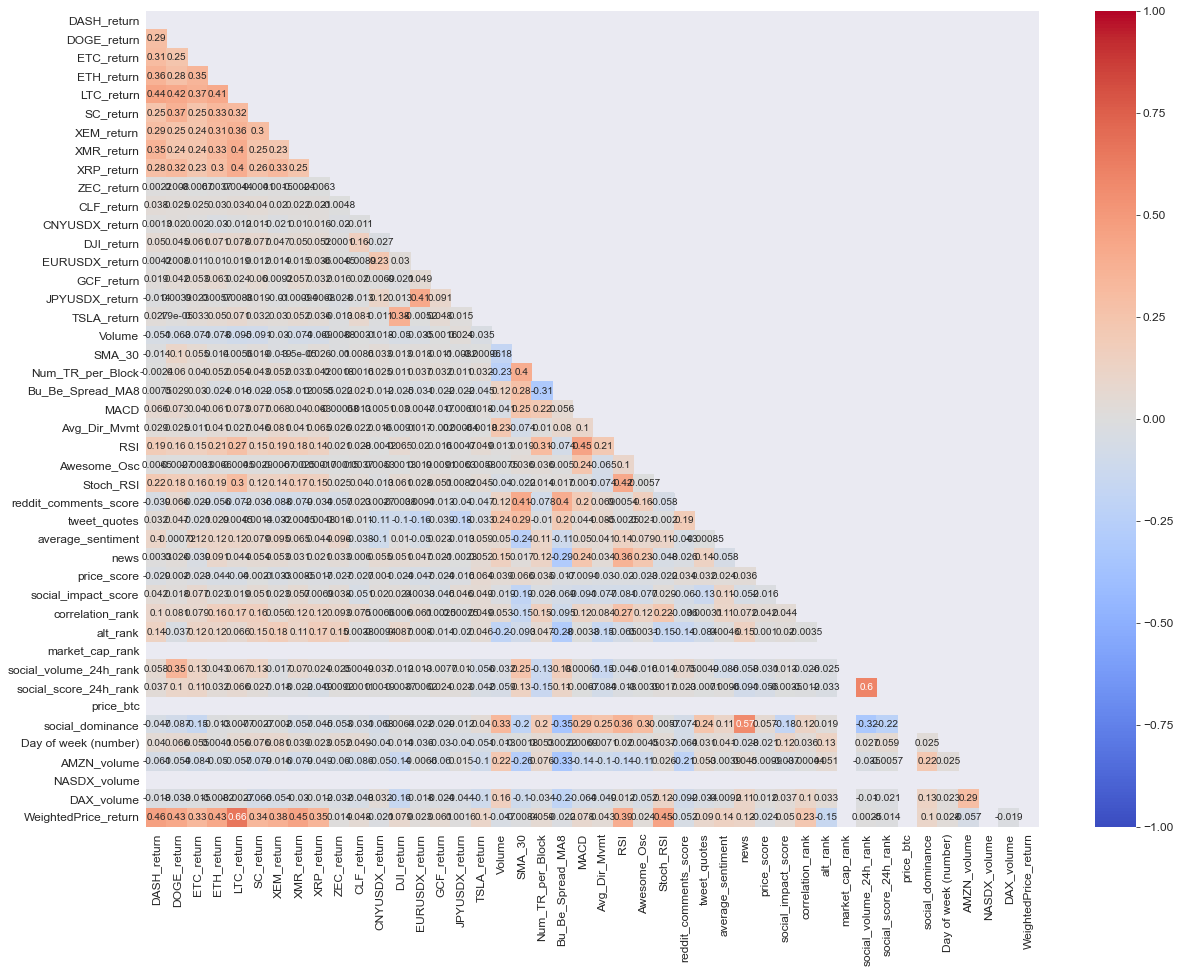

In [28]:
# Correlation Heatmap after Feature Selection

corrmat_new_lags = df_for_model_boost.corr()
fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(corrmat_new_lags)
_ax = sns.heatmap(corrmat_new_lags, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

In [29]:
num_features_boost = corrmat_new_lags.columns

In [30]:
df_num_boost = df_BTC_boosted[num_features_boost]

In [31]:
df_for_model_boost.shape

(2654, 46)

In [32]:
df_for_model_boost.isna().sum()

DASH_return                  0
DOGE_return                  0
ETC_return                   0
ETH_return                   0
LTC_return                   0
SC_return                    0
XEM_return                   0
XMR_return                   0
XRP_return                   0
ZEC_return                   0
CLF_return                   0
CNYUSDX_return               0
DJI_return                   0
EURUSDX_return               0
GCF_return                   0
JPYUSDX_return               0
TSLA_return                  0
Volume                       0
SMA_30                       0
Num_TR_per_Block             0
Bu_Be_Spread_MA8             0
MACD                         0
Avg_Dir_Mvmt                 0
RSI                          0
Awesome_Osc                  0
Stoch_RSI                    0
reddit_comments_score     2076
tweet_quotes              2076
average_sentiment         2076
news                      2076
price_score               2076
social_impact_score       2076
correlat

In [33]:
df_for_model_boost.fillna(method='ffill', inplace=True)

In [34]:
df_for_model_boost.isna().sum()

DASH_return               0
DOGE_return               0
ETC_return                0
ETH_return                0
LTC_return                0
SC_return                 0
XEM_return                0
XMR_return                0
XRP_return                0
ZEC_return                0
CLF_return                0
CNYUSDX_return            0
DJI_return                0
EURUSDX_return            0
GCF_return                0
JPYUSDX_return            0
TSLA_return               0
Volume                    0
SMA_30                    0
Num_TR_per_Block          0
Bu_Be_Spread_MA8          0
MACD                      0
Avg_Dir_Mvmt              0
RSI                       0
Awesome_Osc               0
Stoch_RSI                 0
reddit_comments_score     0
tweet_quotes              0
average_sentiment         0
news                      0
price_score               0
social_impact_score       0
correlation_rank          0
alt_rank                  0
market_cap_rank           0
social_volume_24h_ra

<a id='T'></a>
## <font color='darkblue'>__Train, Test Split and define Preprocessing Pipeline__</font>

In [35]:
crypto_returns = [
    'DASH_return', 
    'DOGE_return', 
    'ETC_return', 
    'ETH_return', 
    'LTC_return', 
    'SC_return',
    'XEM_return',
    'XMR_return',
    'XRP_return',
    'ZEC_return',
]

In [36]:
# Drop alternative coins from the Dataset
df_for_model_boost_min_ALT = df_for_model_boost.drop(columns=crypto_returns)

In [37]:
X = df_for_model_boost_min_ALT.drop('WeightedPrice_return', axis=1) 
y = df_for_model_boost_min_ALT['WeightedPrice_return']

In [38]:
X.shape

(2654, 35)

In [39]:
y.shape

(2654,)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2654 entries, 2019-10-29 to 2021-02-09
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLF_return              2654 non-null   float64
 1   CNYUSDX_return          2654 non-null   float64
 2   DJI_return              2654 non-null   float64
 3   EURUSDX_return          2654 non-null   float64
 4   GCF_return              2654 non-null   float64
 5   JPYUSDX_return          2654 non-null   float64
 6   TSLA_return             2654 non-null   float64
 7   Volume                  2654 non-null   float64
 8   SMA_30                  2654 non-null   float64
 9   Num_TR_per_Block        2654 non-null   float64
 10  Bu_Be_Spread_MA8        2654 non-null   float64
 11  MACD                    2654 non-null   float64
 12  Avg_Dir_Mvmt            2654 non-null   float64
 13  RSI                     2654 non-null   float64
 14  Awesome_Osc             2654 n

In [41]:
# Simple 70-30% Splitting, no shuffling to respect the time series nature of the data
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [42]:
X_train.shape, y_train.shape

((1857, 35), (1857,))

In [43]:
X_test.shape, y_train.shape

((797, 35), (1857,))

### Build Pipeline: Column transformer

In [44]:
# Define numerical and categorical features
categorical_features = X.select_dtypes(include='object').columns
continuous_features = X.select_dtypes(exclude='object').columns
final_dataset_columns = X.columns.values

In [45]:
# Define Scaler and Column Transformer and a Prerocessor Pipeline 
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers = [("num", numeric_transformer, continuous_features),
                    ("cat", categorical_transformer, categorical_features)])

In [46]:
def set_pipeline(name, model):
    pipelined_model = Pipeline([("col_transformer", preprocessor), 
                         (name, model)])
    return pipelined_model

<a id='M'></a>
## <font color='darkblue'>__Initial Model Exploration__</font>

### Daily Returns

In [47]:
# Setup Models to evaluate

lr_regr = LinearRegression()
twd_regr = TweedieRegressor()
psa_regr = PassiveAggressiveRegressor()
sgd_regr = SGDRegressor()
ri_regr = Ridge()
br_regr = BayesianRidge()
ls_regr = Lasso(alpha=0.1)
ll_regr = LassoLars(alpha=0.1)
en_regr = ElasticNet(alpha=0.1)
knn_regr = KNeighborsRegressor()
dt_regr = DecisionTreeRegressor()
rf_regr = RandomForestRegressor()
xg_regr = xgb.XGBRegressor()

# List of the models as the input for the fitting loop
models = [
    ('LR', lr_regr),
    ('Tweedie', twd_regr),
    ('PassiveAggressive', psa_regr),
    ('SGD', sgd_regr),
    ('Ridge', ri_regr),
    ('BayesianRidge', br_regr),
    ('Lasso', ls_regr),
    ('LARSLasso', ll_regr),
    ('ElasticNet', en_regr),
    ('KNN regression', knn_regr),
    ('DecisionTree', dt_regr),
    ('RandomForest', rf_regr),
    ('XGBoost', xg_regr)
]

### Quick Evaluation based on the mainstream metrics

#### Performance Scores

In [48]:
pipelined_models = {} 
scores_init_train = {}
scores_init_test = {}
y_trs = {}
y_hats = {}

for name, model in models:
    pipelined_model = set_pipeline(name, model)
    pipelined_models[name] = {
        pipelined_model
    }
    
    # Model Training
    pipelined_model.fit(X_train, y_train)
        
    # Prediction on X_train
    y_tr = pipelined_model.predict(X_train)
    y_trs[name] = y_tr
    
    # Prediction on X_test
    y_hat = pipelined_model.predict(X_test)
    y_hats[name] = y_hat
    
    
    # Calculation of the Model Performance KPIs on the Training Set
    EVS_tr = (explained_variance_score(y_train, y_tr))
    ME_tr = (max_error(y_train, y_tr))
    MAE_tr = (mean_absolute_error(y_train, y_tr))
    MAPE_tr = (mean_absolute_percentage_error(y_train, y_tr))    
    MSE_tr = (mean_squared_error(y_train, y_tr))
    RMSE_tr = np.sqrt(mean_squared_error(y_train, y_tr))
    R2_tr = r2_score(y_train, y_tr)
    Adj_R2_tr = adjusted_r2_score(y_train, y_tr, X_train)

    scores_init_train[name] = {
                             'EVS_train': EVS_tr,
                             'ME_train': ME_tr,
                             'MAE_train': MAE_tr,
                             'MAPE_train': MAPE_tr,
                             'MSE_train': MSE_tr,
                             'RMSE_train': RMSE_tr,
                             'R2_train': R2_tr,
                             'Adj_R2_train': Adj_R2_tr
    }
    
    
    # Calculation of the Model Performance KPIs on the Test Set
    EVS = (explained_variance_score(y_test, y_hat))
    ME = (max_error(y_test, y_hat))
    MAE = (mean_absolute_error(y_test, y_hat))
    MAPE = (mean_absolute_percentage_error(y_test, y_hat))    
    MSE = (mean_squared_error(y_test, y_hat))
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat))
    R2 = r2_score(y_test, y_hat)
    Adj_R2 = adjusted_r2_score(y_test, y_hat, X_test)

    scores_init_test[name] = {
                             'EVS_test': EVS,
                             'ME_test': ME,
                             'MAE_test': MAE,
                             'MAPE_test': MAPE,
                             'MSE_test': MSE,
                             'RMSE_test': RMSE,
                             'R2_test': R2,
                             'Adj_R2_test': Adj_R2
    }

In [49]:
df_scores_init_train = pd.DataFrame(scores_init_train).round(decimals=4).T
df_scores_init_train = df_scores_init_train[df_scores_init_train['Adj_R2_train']>0.4]

In [50]:
df_scores_init_test = pd.DataFrame(scores_init_test).round(decimals=4).T
df_scores_init_test = df_scores_init_test[df_scores_init_test['Adj_R2_test']>0]

In [51]:
df_scores_init_train.sort_values('Adj_R2_train', ascending=False)

,EVS_train,ME_train,MAE_train,MAPE_train,MSE_train,RMSE_train,R2_train,Adj_R2_train
DecisionTree,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
XGBoost,0.9861,0.0229,0.0026,0.6367,0.0000,0.0038,0.9861,0.9858
RandomForest,0.9108,0.1378,0.0061,1.0559,0.0001,0.0096,0.9108,0.9091
KNN regression,0.4467,0.3274,0.0153,2.2588,0.0006,0.0239,0.4467,0.4361


In [52]:
df_scores_init_test.sort_values('Adj_R2_test', ascending=False)

,EVS_test,ME_test,MAE_test,MAPE_test,MSE_test,RMSE_test,R2_test,Adj_R2_test
RandomForest,0.4454,0.1752,0.0192,1.8850,0.0008,0.0277,0.4454,0.4199
XGBoost,0.3823,0.2031,0.0204,2.0630,0.0009,0.0293,0.3821,0.3536
KNN regression,0.2151,0.1961,0.0232,1.9545,0.0011,0.0330,0.2144,0.1782
Tweedie,0.1938,0.2051,0.0231,1.9762,0.0011,0.0334,0.1937,0.1566


In [53]:
df_scores_init_train.columns = ['EVS', 'ME', 'MAE', 'MAPE', 'MSE',
                                'RMSE', 'R2', 'Adj_R2']

In [54]:
df_scores_init_test.columns = ['EVS', 'ME', 'MAE', 'MAPE', 'MSE',
                               'RMSE', 'R2', 'Adj_R2']

In [55]:
df_scores_init_train['traint'] = 'training'

In [56]:
df_scores_init_test['traint'] = 'initial test'

In [57]:
df_scores_init_merged =pd.concat([df_scores_init_train, df_scores_init_test])

In [58]:
df_scores_init_merged

,EVS,ME,MAE,MAPE,MSE,RMSE,R2,Adj_R2,traint
KNN regression,0.4467,0.3274,0.0153,2.2588,0.0006,0.0239,0.4467,0.4361,training
DecisionTree,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,training
RandomForest,0.9108,0.1378,0.0061,1.0559,0.0001,0.0096,0.9108,0.9091,training
XGBoost,0.9861,0.0229,0.0026,0.6367,0.0000,0.0038,0.9861,0.9858,training
Tweedie,0.1938,0.2051,0.0231,1.9762,0.0011,0.0334,0.1937,0.1566,initial test
KNN regression,0.2151,0.1961,0.0232,1.9545,0.0011,0.0330,0.2144,0.1782,initial test
RandomForest,0.4454,0.1752,0.0192,1.8850,0.0008,0.0277,0.4454,0.4199,initial test
XGBoost,0.3823,0.2031,0.0204,2.0630,0.0009,0.0293,0.3821,0.3536,initial test


#### Initial Model Performance Chart

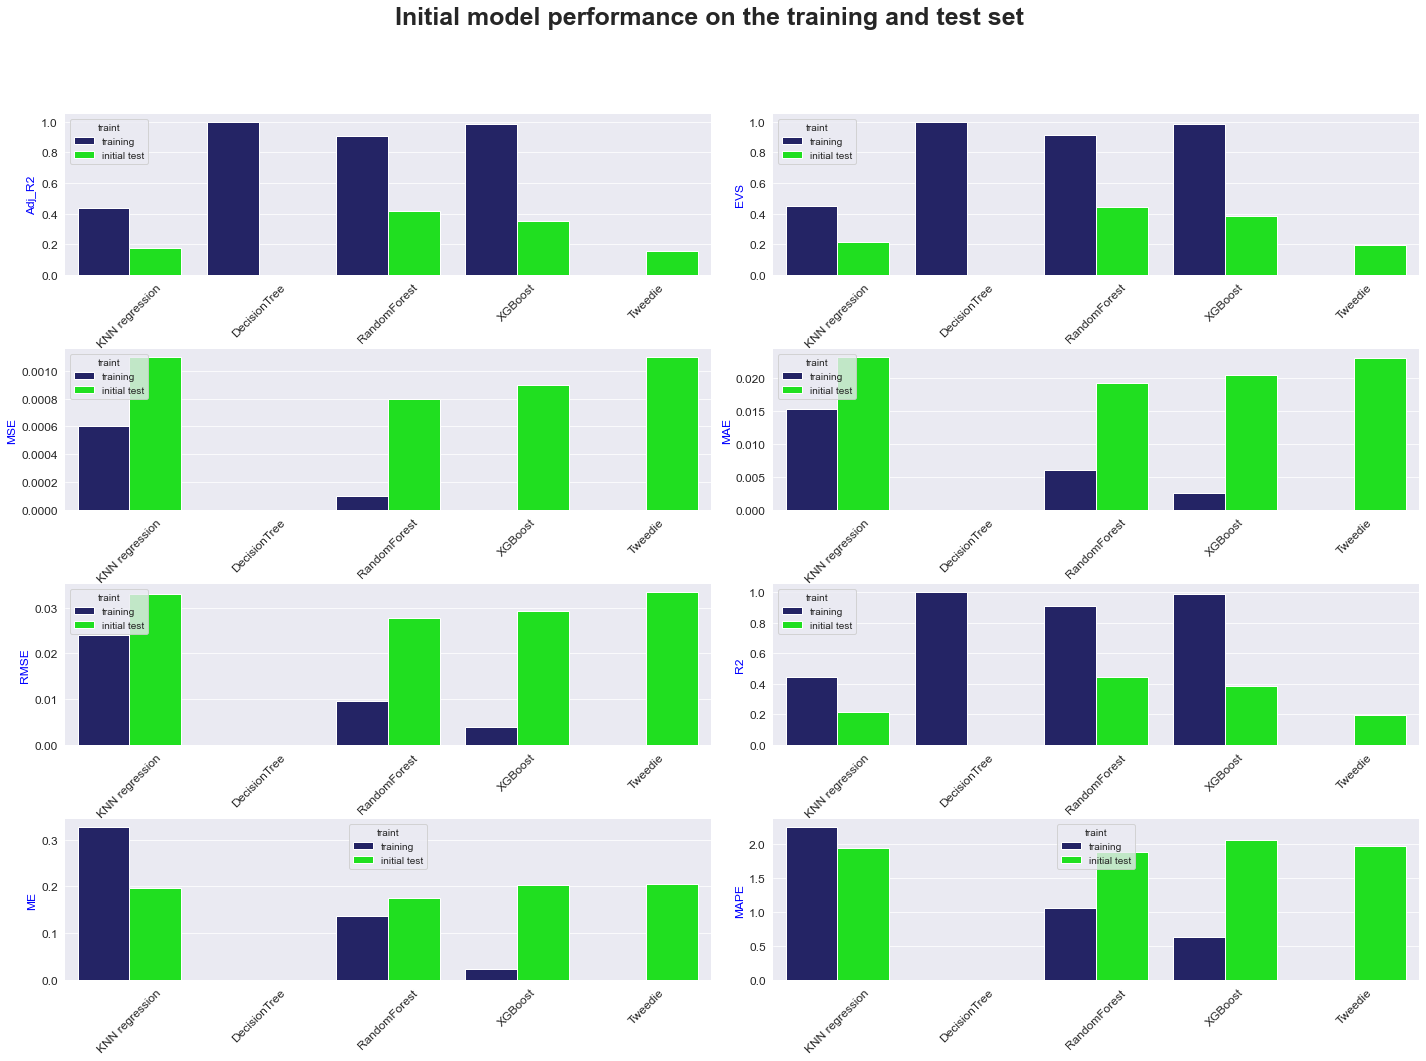

In [59]:
score_col = set(df_scores_init_merged.columns) - set(['traint'])

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,15))
for feat_num, feat_name in enumerate(score_col):
    sns.barplot(data=df_scores_init_merged, x=df_scores_init_merged.index, y=df_scores_init_merged[feat_name],
                hue='traint', ax=axs[int(feat_num/2), feat_num%2], palette=['midnightblue', 'lime'])
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_scores_init_merged):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Initial model performance on the training and test set", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a id='C'></a>
## <font color='darkblue'>__Cross-Validation__</font>

In [60]:
# We make a fresh set of training and test set and we set aside the test to be untouched
X_inter, X_test_new, y_inter, y_test_new = train_test_split(X, y, test_size = 0.3, shuffle = False, stratify =None)

### Train, Validation and Test Split using TimeSeries Split

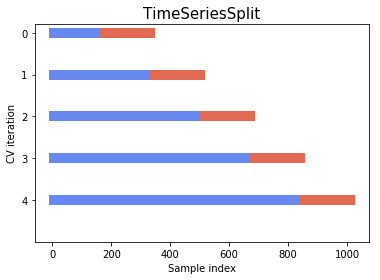

In [61]:
from IPython.display import Image
Image(filename=data_path+'\\07_img\\TimeSeries-Split.png')

In [62]:
# Instantiating a Time-Series Split instance instead of random shuffling, we use a Forward-Walk CV
tscv = TimeSeriesSplit(n_splits=5)

In [63]:
train_test_split = tscv.split(X_inter)

for train, test in train_test_split:
    X_train_cv, y_train_cv = X.iloc[train], y.iloc[train]
    X_test_cv, y_test_cv = X.iloc[test], y.iloc[test]
    
    test_length = len(X_test_cv)
    train_cv_split = [(list(range(train[0],train[-test_length])),
                       list(range(train[-test_length],train[-1]+1)))]
    
    print("Training:" , X_train_cv.index[0], "--", X_train_cv.index[-test_length-1],
          ", Cv:"     , X_train_cv.index[-test_length], "--", X_train_cv.index[-1],
          ", Test:"   , X_test_cv.index[0], "--", X_test_cv.index[-1])

Training: 2019-10-29 -- 2019-10-31 , Cv: 2019-11-01 -- 2020-09-08 , Test: 2020-09-09 -- 2014-04-10
Training: 2019-10-29 -- 2020-09-08 , Cv: 2020-09-09 -- 2014-04-10 , Test: 2014-04-11 -- 2015-02-13
Training: 2019-10-29 -- 2014-04-10 , Cv: 2014-04-11 -- 2015-02-13 , Test: 2015-02-14 -- 2015-12-19
Training: 2019-10-29 -- 2015-02-13 , Cv: 2015-02-14 -- 2015-12-19 , Test: 2015-12-20 -- 2016-10-23
Training: 2019-10-29 -- 2015-12-19 , Cv: 2015-12-20 -- 2016-10-23 , Test: 2016-10-24 -- 2017-08-28


[None, None, None, None]

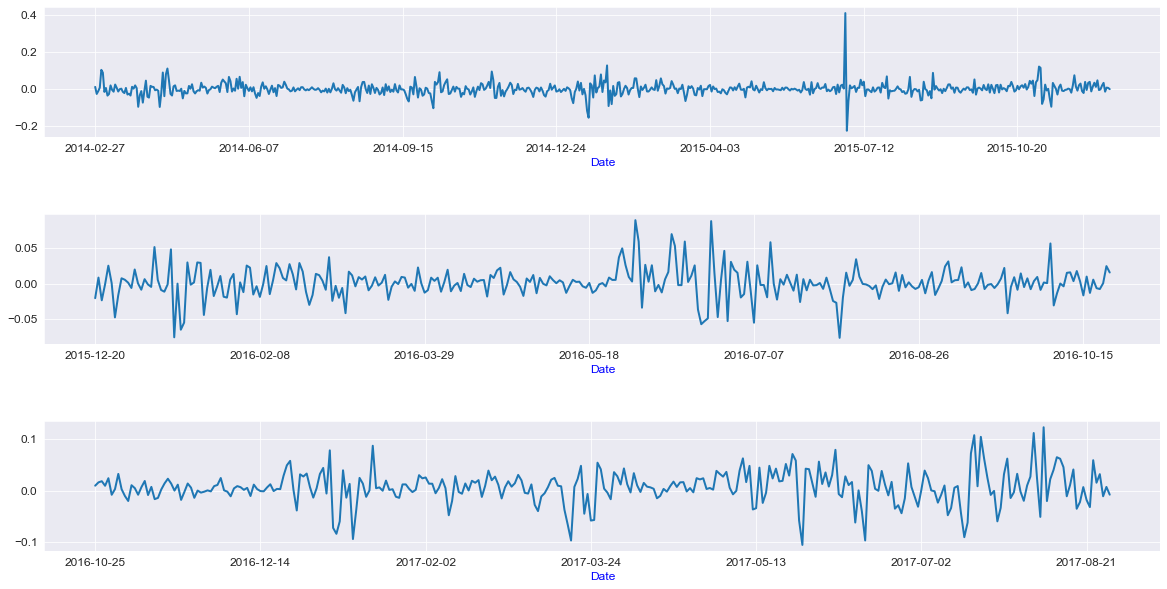

In [64]:
# Plot Training & Test set of Target variable -> TimeSeries Split last Set
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(20, 10))

_ax1 = y_train_cv[y_train_cv.index<=X_train_cv.index[-test_length-1]].plot(ax=axs[0])
_ax2 = y_train_cv[(y_train_cv.index>X_train_cv.index[-test_length-1]) & (y_train_cv.index<=X_train_cv.index[-1])].plot(ax=axs[1])
_ax2 = y_test_cv[(y_test_cv.index>X_test_cv.index[0]) & (y_test_cv.index<=X_test_cv.index[-1])].plot(ax=axs[2])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(fmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

### Cross Validation with TimeSeries Split

In [65]:
model_names = []
score_names = []
scores = []
scores_means = []

tscv_scoring = ['r2', 'explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

for name, model in models:
    pipelined_model = set_pipeline(name, model)
   
    # Cross Val Scores
    for score in tscv_scoring:
        tscv_score = cross_val_score(pipelined_model, X_train_cv, y_train_cv,
                                        scoring=score, cv=tscv)
        model_names.append(name)
        score_names.append(score)
        if score in ('r2', 'explained_variance'):
            scores.append(tscv_score)
            scores_means.append(np.mean(tscv_score))
        else:
            scores.append(-tscv_score)
            scores_means.append(np.mean(-tscv_score))

In [66]:
df_tscv = pd.DataFrame(score_names, 
                       columns=['metric']).merge(pd.DataFrame(scores_means, 
                                                              columns=['score']), 
                                                              left_index=True, right_index=True).merge(pd.DataFrame(model_names, 
                                                                                                                    columns=['model']), 
                                                                                                                    left_index=True, 
                                                                                                                    right_index=True)

In [67]:
df_scores_tscv = df_tscv.pivot_table('score', ['model'], 'metric')

In [68]:
df_scores_tscv.rename(columns={'explained_variance': 'EVS', 'neg_mean_absolute_error': 'MAE', 
                               'neg_mean_squared_error': 'MSE', 'neg_root_mean_squared_error': 'RMSE', 'r2': 'R2'}, inplace=True)

In [69]:
df_scores_tscv.sort_values(by='R2', ascending=False)

metric,EVS,MAE,MSE,RMSE,R2
model,,,,,
RandomForest,3.267566e-01,0.017345,0.000734,0.026276,0.290997
XGBoost,1.070065e-01,0.020051,0.000940,0.029911,0.085541
KNN regression,6.728062e-02,0.020329,0.000998,0.030940,0.030972
ElasticNet,-4.440892e-17,0.020526,0.001046,0.031734,-0.020259
LARSLasso,-4.440892e-17,0.020526,0.001046,0.031734,-0.020259
Lasso,-4.440892e-17,0.020526,0.001046,0.031734,-0.020259
Tweedie,7.922706e-02,0.020877,0.001121,0.032044,-0.060059
DecisionTree,-2.474732e-01,0.025299,0.001384,0.035520,-0.302024
PassiveAggressive,-4.205301e-01,0.025145,0.001519,0.039380,-0.610149


### Train, Validation and Test Split using Blocked Cross Validation

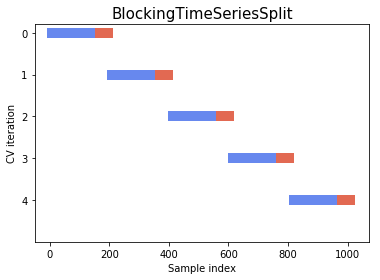

In [70]:
from IPython.display import Image
Image(filename=data_path+'\\07_img\\Blocking-Time-Series-Split.png')

In [71]:
# Define class for Blocking Time Series Split
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

(Ref: PacktHub, Cross-Validation strategies for Time Series forecasting, https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)

In [72]:
# Instantiating a Blocking Time Series Split instance
btscv = BlockingTimeSeriesSplit(n_splits=5)

In [73]:
train_test_split_b = btscv.split(X_inter)

for train_b, test_b in train_test_split_b:
    X_train_bcv, y_train_bcv = X.iloc[train_b], y.iloc[train_b]
    X_test_bcv, y_test_bcv = X.iloc[test_b], y.iloc[test_b]
    
    test_length_bcv = len(X_test_bcv)
    train_bcv_split = [(list(range(train_b[0],train_b[-test_length_bcv])),
                        list(range(train_b[-test_length_bcv],train_b[-1]+1)))]
    
    print("Training:"  , X_train_bcv.index[0], "--", X_train_bcv.index[-test_length_bcv-1],
          ", Cv:"     , X_train_bcv.index[-test_length_bcv], "--", X_train_bcv.index[-1],
          ", Test:"   , X_test_bcv.index[0], "--", X_test_bcv.index[-1])

Training: 2019-10-29 -- 2020-06-07 , Cv: 2020-06-08 -- 2020-08-23 , Test: 2020-08-24 -- 2020-11-07
Training: 2020-11-08 -- 2014-03-12 , Cv: 2014-03-13 -- 2014-05-26 , Test: 2014-05-27 -- 2014-08-09
Training: 2014-08-10 -- 2015-03-18 , Cv: 2015-03-19 -- 2015-06-01 , Test: 2015-06-02 -- 2015-08-15
Training: 2015-08-16 -- 2016-03-23 , Cv: 2016-03-24 -- 2016-06-06 , Test: 2016-06-07 -- 2016-08-20
Training: 2016-08-21 -- 2017-03-29 , Cv: 2017-03-30 -- 2017-06-12 , Test: 2017-06-13 -- 2017-08-26


[None, None, None, None]

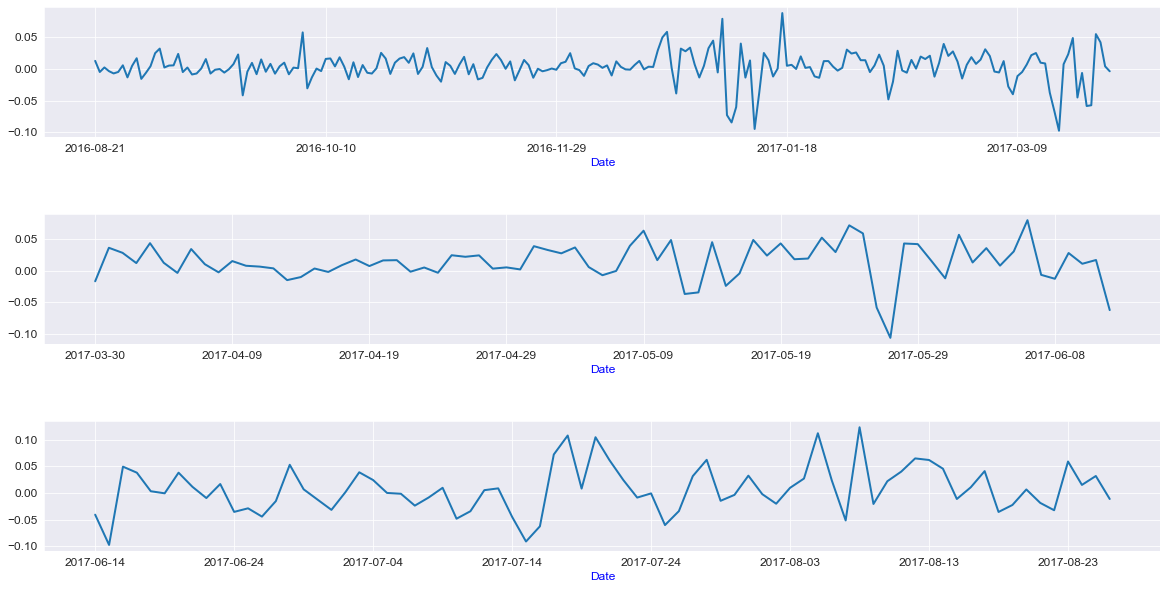

In [74]:
# Plot Training & Test set of Target variable -> Blocking Time Series Split
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(20, 10))

_ax1 = y_train_bcv[y_train_bcv.index<=X_train_bcv.index[-test_length_bcv-1]].plot(ax=axs[0])
_ax2 = y_train_bcv[(y_train_bcv.index>X_train_bcv.index[-test_length_bcv-1]) & (y_train_bcv.index<=X_train_bcv.index[-1])].plot(ax=axs[1])
_ax2 = y_test_bcv[(y_test_bcv.index>X_test_bcv.index[0]) & (y_test_bcv.index<=X_test_bcv.index[-1])].plot(ax=axs[2])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(fmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

### Cross Validation with Blocking Time Series Split

In [75]:
model_names_b = []
score_names_b = []
scores_b = []
scores_means_b = []

btscv_scoring = ['r2', 'explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

for name, model in models:
    pipelined_model = set_pipeline(name, model)
   
    # Cross Val Scores
    for score in btscv_scoring:
        btscv_score = cross_val_score(pipelined_model, X_train_bcv, y_train_bcv,
                                        scoring=score, cv=btscv)
        model_names_b.append(name)
        score_names_b.append(score)
        if score in ('r2', 'explained_variance'):
            scores_b.append(btscv_score)
            scores_means_b.append(np.mean(btscv_score))
        else:
            scores_b.append(-btscv_score)
            scores_means_b.append(np.mean(-btscv_score))

In [76]:
df_btscv = pd.DataFrame(score_names_b, 
                        columns=['metric']).merge(pd.DataFrame(scores_means_b, 
                                                               columns=['score']), 
                                                               left_index=True, 
                                                               right_index=True).merge(pd.DataFrame(model_names_b, 
                                                                                                    columns=['model']), 
                                                                                                    left_index=True, 
                                                                                                    right_index=True)

In [77]:
df_scores_btscv = df_btscv.pivot_table('score', ['model'], 'metric')

In [78]:
df_scores_btscv.rename(columns={'explained_variance': 'EVS', 'neg_mean_absolute_error': 'MAE', 
                               'neg_mean_squared_error': 'MSE', 'neg_root_mean_squared_error': 'RMSE', 'r2': 'R2'}, inplace=True)

In [79]:
df_scores_btscv.sort_values(by='R2', ascending=False)

metric,EVS,MAE,MSE,RMSE,R2
model,,,,,
Tweedie,1.173326e-02,0.013450,0.000342,0.016555,-0.036395
SGD,-9.755801e-03,0.013756,0.000364,0.016794,-0.071439
ElasticNet,-8.881784e-17,0.012760,0.000330,0.016752,-0.092397
LARSLasso,-8.881784e-17,0.012760,0.000330,0.016752,-0.092397
Lasso,-8.881784e-17,0.012760,0.000330,0.016752,-0.092397
KNN regression,-1.938723e-01,0.014120,0.000429,0.018226,-0.219560
RandomForest,6.886752e-02,0.014224,0.000374,0.016444,-0.231334
PassiveAggressive,-1.092187e-03,0.014704,0.000449,0.018735,-0.285446
BayesianRidge,-1.145116e-01,0.015329,0.000409,0.018081,-0.302972


### Model screening for fine-tuning

In [80]:
df_init_to_append = df_scores_init_merged.drop(columns=['ME', 'MAPE', 'Adj_R2'])

In [81]:
df_scores_tscv['traint'] = 'crossval_tscv'

In [82]:
df_scores_btscv['traint'] = 'crossval_btscv'

In [83]:
df_final_scores = pd.concat([df_init_to_append, df_scores_tscv, df_scores_btscv])

In [84]:
df_train_test_cv_scores = df_final_scores[df_final_scores['R2']>0]

In [85]:
df_train_test_cv_scores

,EVS,MAE,MSE,RMSE,R2,traint
KNN regression,0.446700,0.015300,0.000600,0.023900,0.446700,training
DecisionTree,1.000000,0.000000,0.000000,0.000000,1.000000,training
RandomForest,0.910800,0.006100,0.000100,0.009600,0.910800,training
XGBoost,0.986100,0.002600,0.000000,0.003800,0.986100,training
Tweedie,0.193800,0.023100,0.001100,0.033400,0.193700,initial test
KNN regression,0.215100,0.023200,0.001100,0.033000,0.214400,initial test
RandomForest,0.445400,0.019200,0.000800,0.027700,0.445400,initial test
XGBoost,0.382300,0.020400,0.000900,0.029300,0.382100,initial test
KNN regression,0.067281,0.020329,0.000998,0.030940,0.030972,crossval_tscv
RandomForest,0.326757,0.017345,0.000734,0.026276,0.290997,crossval_tscv


#### Cross-Validated Model Performance Chart

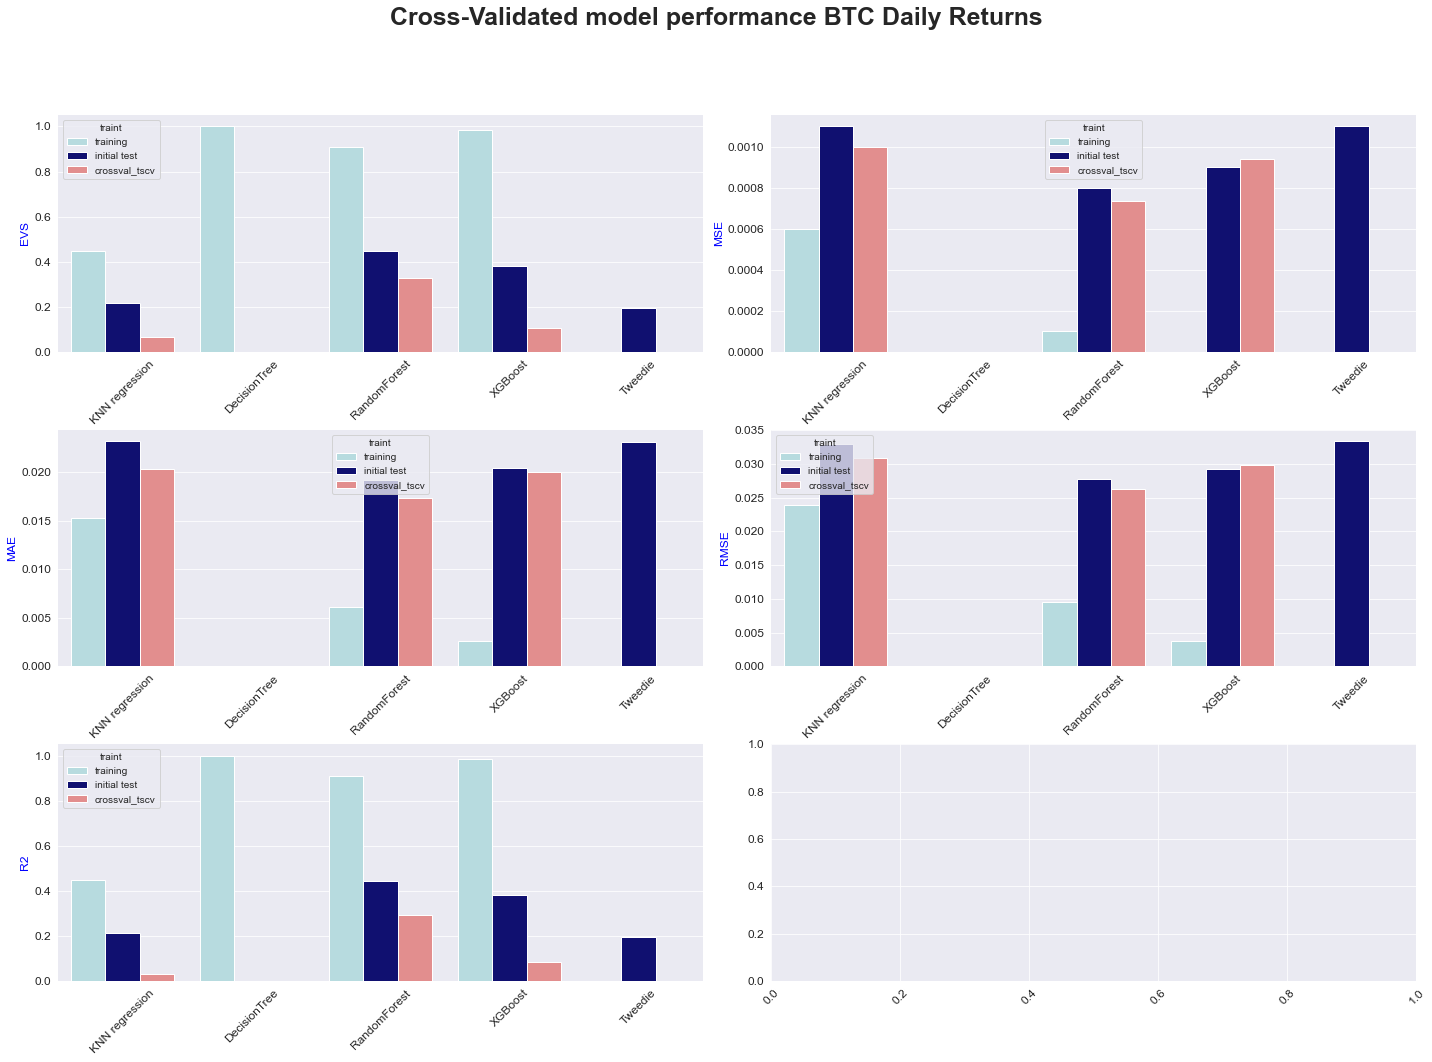

In [86]:
cv_score_col = set(df_train_test_cv_scores.columns) - set(['traint'])

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
for feat_num, feat_name in enumerate(cv_score_col):
    sns.barplot(data=df_train_test_cv_scores, x=df_train_test_cv_scores.index, y=df_train_test_cv_scores[feat_name],
                hue='traint', ax=axs[int(feat_num/2), feat_num%2], palette=['powderblue', 'navy', 'lightcoral', 'indianred'])
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_train_test_cv_scores):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Cross-Validated model performance BTC Daily Returns", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a id='H'></a>
## <font color='darkblue'>__Hyperparameter Tuning__</font>

### Extract Initial Parameters

In [87]:
# Get the initial parameters for the base models
initial_params = {
    'Tweedie Regressor': twd_regr.get_params(),
    'SGD Regressor': sgd_regr.get_params(),
    'KNN Regressor': knn_regr.get_params(),
    'Random Forest Regressor': rf_regr.get_params(),
    'XG Boost Regressor': xg_regr.get_params()
 }

### Grid Search

### Tweedie Regressor

In [88]:
initial_params['Tweedie Regressor']

{'alpha': 1.0,
 'fit_intercept': True,
 'link': 'auto',
 'max_iter': 100,
 'power': 0.0,
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [89]:
pipe_twd = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', TweedieRegressor())])

#### Run Cross-Validation with Grid Search

In [90]:
# Setup parameters

alpha = [0.01, 0.02, 0.03, 0.05, 1.0, 2.0, 3.0, 5.0]
fit_intercept = [True]
link = ['auto']
max_iter = [50000]
power = [0.0, 1.0, 2.0, 3.0]
tol = [0.0001]
warm_start = [False]
col_transformer = [preprocessor]

# Hyperparameter Optimization
twd_grid_search = {'col_transformer': col_transformer,
                    'regressor__power': power, 
                    'regressor__alpha': alpha, 
                    'regressor__fit_intercept': fit_intercept, 
                    'regressor__link': link,
                    'regressor__max_iter': max_iter,
                    'regressor__tol': tol,
                    'regressor__warm_start': warm_start,
                    }


# Run Grid Serch
scores_grid_twd = cross_val_score(GridSearchCV(estimator=pipe_twd,
                                                  param_grid=twd_grid_search,
                                                  cv=btscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_bcv, y_train_bcv, cv=btscv)
                         
print("TWD Cross-validation scores (R2): ", scores_grid_twd)
print("TWD Mean cross-validation score (R2): ", scores_grid_twd.mean())

TWD Cross-validation scores (R2):  [ 0.04309565  0.24438453  0.18800302 -0.50594894 -0.10849816]
TWD Mean cross-validation score (R2):  -0.02779277906004456


#### Run Grid Search & Select Best Estimator

In [91]:
# Run Tweedie Grid Serch Fit
clf_twd_grid = GridSearchCV(estimator=pipe_twd,
                            param_grid=twd_grid_search,
                            cv=tscv,
                            scoring='r2',
                            verbose = 3,
                            n_jobs = -1)                         

search_twd_grid = clf_twd_grid.fit(X_train_cv, y_train_cv)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [92]:
pd.set_option('max_colwidth', None)
results_twd = pd.DataFrame(search_twd_grid.cv_results_)
results_twd = results_twd[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_twd[results_twd['rank_test_score']<=3]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
28,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__alpha': 5.0, 'regressor__fit_intercept': True, 'regressor__link': 'auto', 'regressor__max_iter': 50000, 'regressor__power': 0.0, 'regressor__tol': 0.0001, 'regressor__warm_start': False}",1,0.032065,0.118480,-0.199799,0.085205,0.096638,0.050941,0.127339
24,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__alpha': 3.0, 'regressor__fit_intercept': True, 'regressor__link': 'auto', 'regressor__max_iter': 50000, 'regressor__power': 0.0, 'regressor__tol': 0.0001, 'regressor__warm_start': False}",2,0.024895,0.196969,-0.363800,0.118781,0.129753,0.069624,0.170120
20,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__alpha': 2.0, 'regressor__fit_intercept': True, 'regressor__link': 'auto', 'regressor__max_iter': 50000, 'regressor__power': 0.0, 'regressor__tol': 0.0001, 'regressor__warm_start': False}",3,0.006798,0.279744,-0.547676,0.141800,0.152917,0.084714,0.202235


In [93]:
best_model_twd = search_twd_grid.best_estimator_['regressor']

In [94]:
best_model_twd

TweedieRegressor(alpha=5.0, max_iter=50000)

### SGD Regressor

In [95]:
initial_params['SGD Regressor']

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [96]:
pipe_sgd = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', SGDRegressor())])

#### Run Cross-Validation with Grid Search

In [97]:
# Setup parameters
alpha = [0.0001]
average = [False]
early_stopping = [False]
epsilon = [0.1, 0.15, 0.2]
eta0 = [0.01]
fit_intercept = [True]
l1_ratio = [0.15]
learning_rate = ['invscaling']
loss = ['squared_loss']
max_iter = [100000]
n_iter_no_change = [5]
penalty = ['l2']
power_t =  [0.25, 0.3, 0.5]
random_state = [None]
shuffle = [False]
tol = [0.001]
validation_fraction = [0.1, 0.2, 0.3]
warm_start = [False, True]
col_transformer = [preprocessor]

# Hyperparameter Optimization
sgd_grid_search = {'col_transformer': col_transformer,
                    'regressor__average': average,
                    'regressor__early_stopping': early_stopping,
                    'regressor__epsilon': epsilon, 
                    'regressor__eta0': eta0, 
                    'regressor__fit_intercept': fit_intercept, 
                    'regressor__l1_ratio': l1_ratio, 
                    'regressor__learning_rate': learning_rate,
                    'regressor__loss': loss,
                    'regressor__max_iter': max_iter,
                    'regressor__n_iter_no_change': n_iter_no_change, 
                    'regressor__penalty': penalty, 
                    'regressor__power_t': power_t,
                    'regressor__random_state': random_state,
                    'regressor__shuffle': shuffle,
                    'regressor__tol': tol,
                    'regressor__validation_fraction': validation_fraction,
                    'regressor__warm_start': warm_start
                    }


# Run Grid Serch
scores_grid_sgd = cross_val_score(GridSearchCV(estimator=pipe_sgd,
                                                  param_grid=sgd_grid_search,
                                                  cv=tscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
                         
print("SGD Cross-validation scores (R2): ", scores_grid_sgd)
print("SGD Mean cross-validation score (R2): ", scores_grid_sgd.mean())

SGD Cross-validation scores (R2):  [-1.30363602  0.18826868  0.16658625  0.12641791  0.23936558]
SGD Mean cross-validation score (R2):  -0.116599517821475


#### Run Grid Search & Select Best Estimator

In [98]:
# Run Grid Search Fit
clf_sgd_grid = GridSearchCV(estimator=pipe_sgd,
                            param_grid=sgd_grid_search,
                            cv=tscv,
                            scoring='r2',
                            verbose = 0,
                            n_jobs = -1)                         

search_sgd_grid = clf_sgd_grid.fit(X_train_cv, y_train_cv)

In [99]:
pd.set_option('max_colwidth', None)
results_sgd = pd.DataFrame(search_sgd_grid.cv_results_)
results_sgd = results_sgd[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_sgd[results_sgd['rank_test_score']<=3]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
53,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__average': False, 'regressor__early_stopping': False, 'regressor__epsilon': 0.2, 'regressor__eta0': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.15, 'regressor__learning_rate': 'invscaling', 'regressor__loss': 'squared_loss', 'regressor__max_iter': 100000, 'regressor__n_iter_no_change': 5, 'regressor__penalty': 'l2', 'regressor__power_t': 0.5, 'regressor__random_state': None, 'regressor__shuffle': False, 'regressor__tol': 0.001, 'regressor__validation_fraction': 0.3, 'regressor__warm_start': True}",1,-0.1166,0.594637,-1.303636,0.188269,0.166586,0.126418,0.239366
30,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__average': False, 'regressor__early_stopping': False, 'regressor__epsilon': 0.15, 'regressor__eta0': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.15, 'regressor__learning_rate': 'invscaling', 'regressor__loss': 'squared_loss', 'regressor__max_iter': 100000, 'regressor__n_iter_no_change': 5, 'regressor__penalty': 'l2', 'regressor__power_t': 0.5, 'regressor__random_state': None, 'regressor__shuffle': False, 'regressor__tol': 0.001, 'regressor__validation_fraction': 0.1, 'regressor__warm_start': False}",1,-0.1166,0.594637,-1.303636,0.188269,0.166586,0.126418,0.239366
31,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__average': False, 'regressor__early_stopping': False, 'regressor__epsilon': 0.15, 'regressor__eta0': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.15, 'regressor__learning_rate': 'invscaling', 'regressor__loss': 'squared_loss', 'regressor__max_iter': 100000, 'regressor__n_iter_no_change': 5, 'regressor__penal

In [100]:
best_model_sgd = search_sgd_grid.best_estimator_['regressor']

In [101]:
best_model_sgd

SGDRegressor(max_iter=100000, power_t=0.5, shuffle=False)

### Random Forest Regressor

In [102]:
initial_params['Random Forest Regressor']

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [103]:
pipe_rf = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', RandomForestRegressor())])

#### Run Cross-Validation with Grid Search

In [104]:
# Setup parameters
n_estimators = [100]
max_features = ['auto']
max_depth = [2, 5]
max_depth.append(None)
min_samples_split = [2]
min_samples_leaf = [1]
bootstrap = [True, False]
criterion =  ['mse', 'mae']
warm_start = [True]
col_transformer = [preprocessor]


# Hyperparameter Optimization
rf_grid_search = {'col_transformer': col_transformer,
                    'regressor__n_estimators': n_estimators, 
                    'regressor__max_features': max_features, 
                    'regressor__max_depth': max_depth, 
                    'regressor__min_samples_split': min_samples_split,
                    'regressor__min_samples_leaf': min_samples_leaf,
                    'regressor__bootstrap': bootstrap,
                    'regressor__criterion': criterion,
                    'regressor__warm_start': warm_start
                    }


# Run Grid Serch
scores_grid_rf = cross_val_score(GridSearchCV(estimator=pipe_rf,
                                                  param_grid=rf_grid_search,
                                                  cv=tscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
                         
print("RF Cross-validation scores (R2): ", scores_grid_rf)
print("RF Mean cross-validation score (R2): ", scores_grid_rf.mean())

RF Cross-validation scores (R2):  [0.4100206  0.37460645 0.42711409 0.22512579 0.34921144]
RF Mean cross-validation score (R2):  0.35721567653509145


#### Run Grid Search & Select Best Estimator

In [105]:
# Run Grid Search Fit
clf_rf_grid = GridSearchCV(estimator=pipe_rf,
                           param_grid=rf_grid_search,
                           cv=tscv,
                           scoring='r2',
                           verbose = 3,
                           n_jobs = -1)                         

search_rf_grid = clf_rf_grid.fit(X_train_cv, y_train_cv)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [106]:
pd.set_option('max_colwidth', None)
results_rf = pd.DataFrame(search_rf_grid.cv_results_)
results_rf = results_rf[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_rf[results_rf['rank_test_score']<=3]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
4,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__bootstrap': True, 'regressor__criterion': 'mae', 'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__warm_start': True}",1,0.350719,0.068284,0.384165,0.398727,0.415615,0.227699,0.327388
5,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__bootstrap': True, 'regressor__criterion': 'mae', 'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__warm_start': True}",2,0.346718,0.064577,0.396886,0.389884,0.379733,0.222722,0.344367
3,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__bootstrap': True, 'regressor__criterion': 'mae', 'regressor__max_depth': 2, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__warm_start': True}",3,0.295694,0.072402,0.267964,0.347645,0.402049,0.192288,0.268521


In [107]:
best_model_rf = search_rf_grid.best_estimator_['regressor']

In [108]:
best_model_rf

RandomForestRegressor(criterion='mae', max_depth=5, warm_start=True)

### Feature Importance 

Trees based models like RandomForest, XGBoost, etc.  provide us feature importance based on the training.

In [109]:
rfc_model = pipe_rf['regressor']

In [110]:
pipe_rf['col_transformer'].transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return',
         'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30',
         'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI',
         'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes',
         'average_sentiment', 'news', 'price_score', 'social_impact_score',
         'correlation_rank', 'alt_rank', 'market_cap_rank',
         'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc',
         'social_dominance', 'Day of week (number)', 'AMZN_volume',
         'NASDX_volume', 'DAX_volume'],
        dtype='object')),
 ('cat',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]

In [111]:
num_feat = list(pipe_rf['col_transformer'].transformers_[0][2])
cat_feat = list(pipe_rf['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

In [112]:
feature_columns = num_feat+cat_feat

In [113]:
rfc_importances = pd.DataFrame(
    {"feature": feature_columns, "importance": np.round(best_model_rf.feature_importances_, 3)}
)
rfc_importances = rfc_importances.sort_values("importance", ascending=True).set_index(
    "feature"
)

<AxesSubplot:ylabel='feature'>

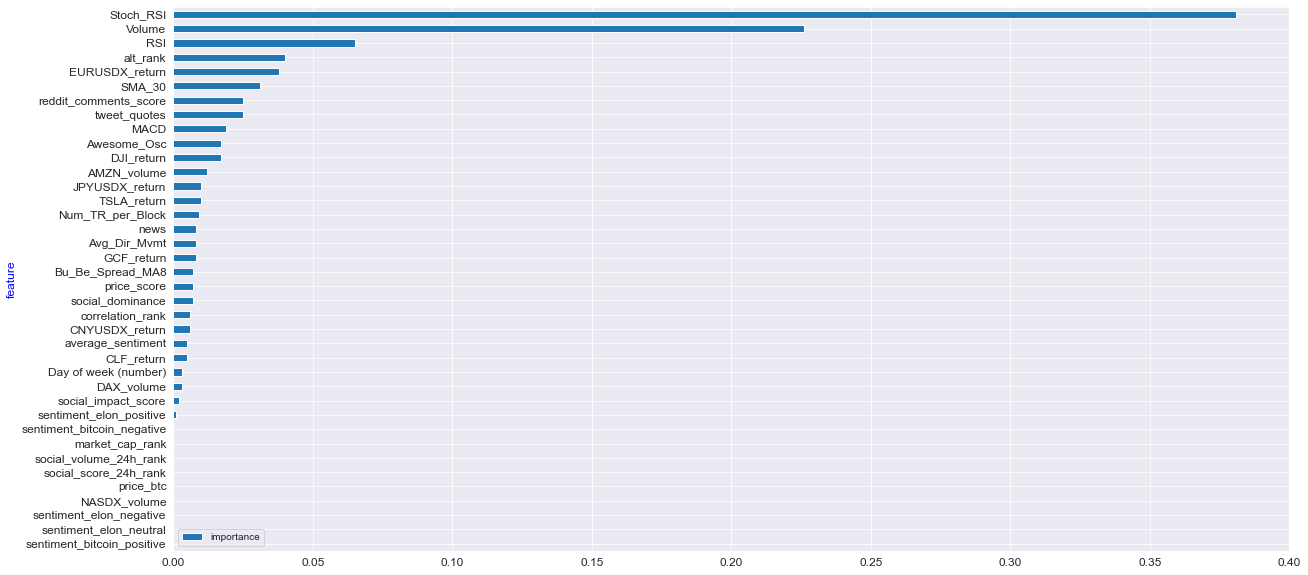

In [114]:
f,ax = plt.subplots(figsize=(20,10)) 
rfc_importances.plot(kind="barh",ax=ax)

### XGBoost Regressor

In [115]:
initial_params['XG Boost Regressor']

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [116]:
pipe_xgb = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', xgb.XGBRegressor())])

#### Run Cross-Validation with Grid Search

In [117]:
# Setup parameters
objective = ['reg:squarederror']
learning_rate = [0.29, 0.300000012, 0.31]
max_depth = [6, 7, 8, 50]
n_estimators = [1000]
subsample = [1]
min_child_weight = [1]
colsample_bytree = [1]
col_transformer = [preprocessor]


# Hyperparameter Optimization
xgb_grid_search = {'col_transformer': col_transformer,
                    'regressor__objective': objective, 
                    'regressor__learning_rate': learning_rate, 
                    'regressor__max_depth': max_depth, 
                    'regressor__n_estimators': n_estimators, 
                    'regressor__subsample': subsample,
                    'regressor__min_child_weight': min_child_weight,
                    'regressor__colsample_bytree': colsample_bytree
                    }


# Run Grid Serch
scores_grid_xgb = cross_val_score(GridSearchCV(estimator=pipe_xgb,
                                                  param_grid=xgb_grid_search,
                                                  cv=tscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
                         
print("XGB Cross-validation scores (R2): ", scores_grid_xgb)
print("XGB Mean cross-validation score (R2): ", scores_grid_xgb.mean())

XGB Cross-validation scores (R2):  [ 0.34604356 -0.45176653 -0.44901335  0.12793497  0.22042994]
XGB Mean cross-validation score (R2):  -0.04127428294847322


#### Run Grid Search & Select Best Estimator

In [118]:
# Run Grid Search Fit
clf_xgb_grid = GridSearchCV(estimator=pipe_xgb,
                           param_grid=xgb_grid_search,
                           cv=tscv,
                           scoring='r2',
                           verbose = 0,
                           n_jobs = -1)                         

search_xgb_grid = clf_xgb_grid.fit(X_train_cv, y_train_cv)

In [119]:
pd.set_option('max_colwidth', None)
results_xgb = pd.DataFrame(search_xgb_grid.cv_results_)
results_xgb = results_xgb[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_xgb[results_xgb['rank_test_score']<=5]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
9,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.31, 'regressor__max_depth': 7, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",1,0.093109,0.239159,0.428399,-0.285881,-0.031927,0.183007,0.171949
4,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.300000012, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",2,0.083668,0.205440,0.318090,-0.266519,-0.013983,0.166554,0.214198
10,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.31, 'regressor__max_depth': 8, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",3,0.058046,0.264916,0.405097,-0.364980,-0.088614,0.118297,0.220430
5,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes', 'aver...re', 'correlation_rank', 'alt_rank', 'market_cap_rank', 'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc', 'social_dominance', 'Day of week (number)', 'AMZN_volume', 'NASDX_volume', 'DAX_volume'], dtype='object')), ('cat', P

In [120]:
best_model_xgb = search_xgb_grid.best_estimator_['regressor']

In [121]:
best_model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.31, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Feature Importance 

Trees based models like RandomForest, XGBoost, etc.  provide us feature importance based on the training.

In [122]:
xgb_model = pipe_xgb['regressor']

In [123]:
pipe_xgb['col_transformer'].transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return',
         'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30',
         'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI',
         'Awesome_Osc', 'Stoch_RSI', 'reddit_comments_score', 'tweet_quotes',
         'average_sentiment', 'news', 'price_score', 'social_impact_score',
         'correlation_rank', 'alt_rank', 'market_cap_rank',
         'social_volume_24h_rank', 'social_score_24h_rank', 'price_btc',
         'social_dominance', 'Day of week (number)', 'AMZN_volume',
         'NASDX_volume', 'DAX_volume'],
        dtype='object')),
 ('cat',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]

In [124]:
num_feat = list(pipe_xgb['col_transformer'].transformers_[0][2])
cat_feat = list(pipe_xgb['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

In [125]:
feature_columns = num_feat+cat_feat

In [126]:
xgb_importances = pd.DataFrame(
    {"feature": feature_columns, "importance": np.round(best_model_xgb.feature_importances_, 3)}
)
xgb_importances = xgb_importances.sort_values("importance", ascending=True).set_index(
    "feature"
)

<AxesSubplot:ylabel='feature'>

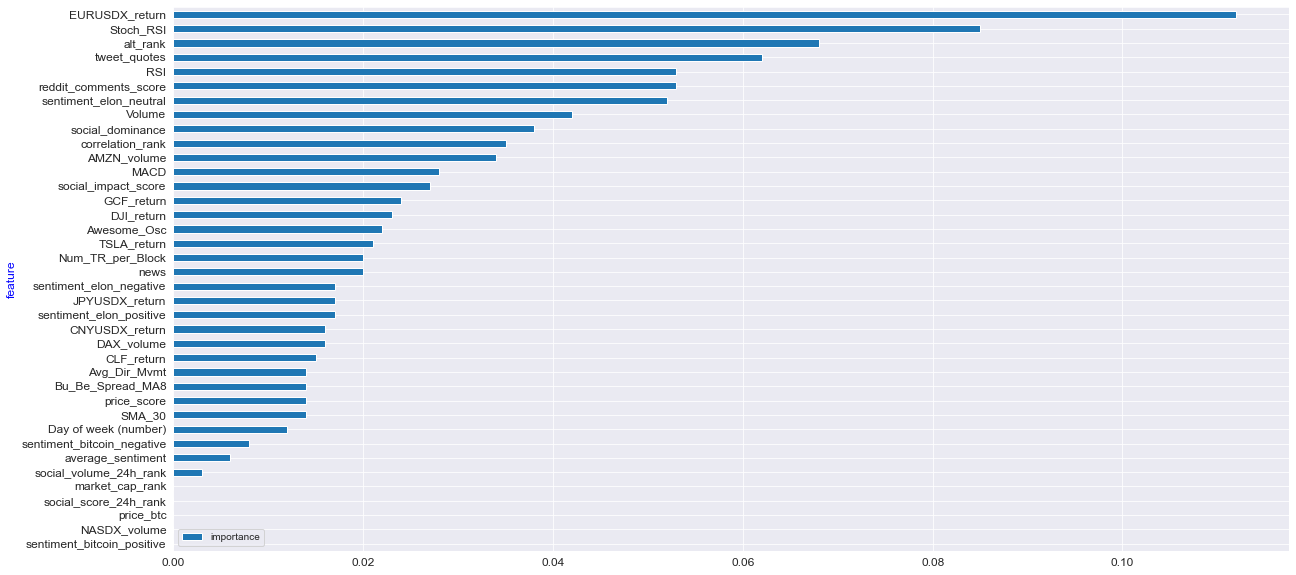

In [127]:
f,ax = plt.subplots(figsize=(20,10)) 
xgb_importances.plot(kind="barh",ax=ax)

### Grid Search Scores

#### Get the best models and their parameters from the Optimization

In [128]:
# Get the best estimator pipelines after fitted Grid Search for the final models
final_models = {
    'Tweedie': search_twd_grid.best_estimator_,
    'SGD': search_sgd_grid.best_estimator_,
    'RandomForest': search_rf_grid.best_estimator_,
    'XGBoost': search_xgb_grid.best_estimator_
 }

In [129]:
# Get the optimized parameters after fitted Grid Search for the final models
final_params = {
    'Tweedie': search_twd_grid.best_params_,
    'SGD': search_sgd_grid.best_params_,
    'RandomForest': search_rf_grid.best_params_,
    'XGBoost': search_xgb_grid.best_params_
 }

In [130]:
# Drop the 'col_transformer' from the parameter grid
def without_keys(d, keys):
    return {k:v for k,v in d.items() if k not in keys}

final_params_cleaned = {}
for name, param_dict in final_params.items():
    dict_cleaned = without_keys(param_dict, 'col_transformer')
    final_params_cleaned[name] = dict_cleaned    

In [131]:
# Create new parameter dictionary with a one-item list for the paramater values
final_params_dict = {}
param_dict = {}

for grid_dict in final_params_cleaned.keys():
    for param, param_value in final_params_cleaned[grid_dict].items():
        param_val_list = []
        param_val_list.append(param_value)
        param_dict[param] = param_val_list
        param_val_list = []
    final_params_dict[grid_dict] = param_dict
    param_dict = {}

#### Get all the relevant Scores from a Cross-Validation of the fitted best tuned Models 

In [132]:
model_names_final = []
score_names_final = []
scores_final = []
scores_means_final = []

scoring_grid_final = ['r2', 'explained_variance', 
                      'neg_mean_absolute_error', 
                      'neg_mean_squared_error', 
                      'neg_root_mean_squared_error']

for est_name, est_model in final_models.items():
    
    # Cross Val Scores
    for score in scoring_grid_final:
        final_grid_score = cross_val_score(GridSearchCV(estimator=est_model,
                                                        param_grid=final_params_dict[est_name],
                                                        cv=tscv,
                                                        scoring=score,
                                                        verbose = 0,
                                                        n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
        model_names_final.append(est_name)
        score_names_final.append(score)
        if score in ('r2', 'explained_variance'):
            scores_final.append(final_grid_score)
            scores_means_final.append(np.mean(final_grid_score))
        else:
            scores_final.append(-final_grid_score)
            scores_means_final.append(np.mean(-final_grid_score))

In [133]:
df_grid_tscv = pd.DataFrame(score_names_final, 
                             columns=['metric']).merge(pd.DataFrame(scores_means_final, 
                                                                    columns=['score']), 
                                                                    left_index=True, 
                                                                    right_index=True).merge(pd.DataFrame(model_names_final, 
                                                                                                         columns=['model']), 
                                                                                                         left_index=True, 
                                                                                                         right_index=True)

In [134]:
df_grid_scores_tscv = df_grid_tscv.pivot_table('score', ['model'], 'metric')
df_grid_scores_tscv.rename(columns={'explained_variance': 'EVS', 'neg_mean_absolute_error': 'MAE', 
                                    'neg_mean_squared_error': 'MSE', 'neg_root_mean_squared_error': 'RMSE', 'r2': 'R2'}, inplace=True)

In [135]:
df_grid_scores_tscv['traint'] = 'grid search cv'

In [136]:
df_grid_scores_tscv.sort_values(by='R2', ascending=False)

metric,EVS,MAE,MSE,RMSE,R2,traint
model,,,,,,
RandomForest,0.357111,0.016665,0.000680,0.025269,0.348010,grid search cv
XGBoost,0.095692,0.019557,0.000922,0.029604,0.093109,grid search cv
Tweedie,0.079859,0.019991,0.001006,0.030978,0.032065,grid search cv
SGD,0.059444,0.021540,0.001181,0.032623,-0.116600,grid search cv


<a name='S'></a>
## <font color='darkblue'>__Select final model and save model artifacts__</font>

### Model Artifacts Definition

In [137]:
# Define the path where the models will be saved
model_path = f"{project_dir}\\02_Saved_Models\\01_Main_Models\\"

In [138]:
# Selected models: Model Artifacts definition
final_model_artifacts = {}

for est_name, est_model in final_models.items():
    num_feat_model = list(est_model['col_transformer'].transformers_[0][2])
    cat_feat_model = list(est_model['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))
    feature_columns_model = num_feat_model+cat_feat_model

    final_model_artifacts[est_name] = {
        'cat_init_features': categorical_features,
        'num_init_features': num_feat_model,
        'cat_ohe_features': cat_feat_model,
        'column_names_order': feature_columns_model,
        'col_transformer': est_model['col_transformer'],
        'final_model': est_model,
    }

### Save model artifacts

In [139]:
for est_name, est_model in final_models.items():
    with open(model_path+'crypto_ml_artifacts_'+est_name+'.pkl', "wb") as dill_file:
        dill.dump(final_model_artifacts[est_name], dill_file)

<a name='P'></a>
## <font color='darkblue'>__Prediction and Testing__</font>

### Load saved Model Artifacts

In [140]:
loaded_model_artifacts = {}
for est_name, est_model in final_models.items():
    with open(model_path+'crypto_ml_artifacts_'+est_name+'.pkl', "rb") as dill_infile:
        artifact_file = dill.load(dill_infile)
        loaded_model_artifacts[est_name] = artifact_file

### Prediction

In [141]:
# We use the test dataset we set aside in the beginning of the Cross-Validation round to make predictions
metrics = {}
predictions ={}

for est_name, est_model in final_models.items():
    # Build the pipeline
    pipeline_built = loaded_model_artifacts[est_name]['final_model']
    # Make prediction
    prediction = pipeline_built.predict(X_test_new)
    predictions[est_name] = prediction
    
    # Calculate the metrics for the "goodness of fit"
    EVS = (explained_variance_score(y_test_new, prediction))
    ME = (max_error(y_test_new, prediction))
    MAE = (mean_absolute_error(y_test_new, prediction))
    MSE = (mean_squared_error(y_test_new, prediction))
    RMSE = np.sqrt(mean_squared_error(y_test_new, prediction))
    R2 = r2_score(y_test_new, prediction)
    Adj_R2 = adjusted_r2_score(y_test_new, prediction, X_test_new)

    metrics[est_name] = {
        'EVS': EVS,
        'ME': ME,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'R2': R2,
        'Adj_R2': Adj_R2
    }

### Evaluation

In [142]:
df_final_test_scores = pd.DataFrame(metrics).round(decimals=4).T

In [143]:
df_final_test_scores['traint'] = 'prediction'

In [144]:
# Final test scores after prediction
df_final_test_scores.sort_values('Adj_R2', ascending=False)

,EVS,ME,MAE,MSE,RMSE,R2,Adj_R2,traint
RandomForest,0.3791,0.1856,0.0204,0.0009,0.0294,0.3767,0.3481,prediction
XGBoost,0.3437,0.2079,0.0210,0.0009,0.0302,0.3432,0.3130,prediction
SGD,0.2166,0.2443,0.0231,0.0011,0.0329,0.2165,0.1804,prediction
Tweedie,0.0932,0.1781,0.0244,0.0013,0.0354,0.0931,0.0514,prediction


In [145]:
# Prepare the initial train/test and cross-validation scores for merge
df_train_test_cv_reset = df_train_test_cv_scores.reset_index()
df_train_test_cv_subset = df_train_test_cv_reset[df_train_test_cv_reset['index'].isin(['Tweedie', 'SGD', 'RandomForest', 'XGBoost'])]
df_train_test_cv_subset.set_index('index', inplace=True)

In [146]:
# Merge the scores
df_metrics_merged = pd.concat([df_final_test_scores, df_grid_scores_tscv, df_train_test_cv_subset])

In [147]:
df_metrics_merged['traint'].replace(
                                   {'training': '01_training',
                                    'initial test': '02_initial_test',
                                    'crossval_tscv': '03_crossval_tscv',
                                    'crossval_btscv': '04_crossval_btscv',
                                    'grid search cv': '05_grid_search_cv',
                                    'prediction': '06_prediction'}, inplace=True)

In [148]:
df_final_metrics = df_metrics_merged.drop(columns=['ME', 'Adj_R2']).sort_values(by='traint')

In [149]:
df_final_metrics = df_final_metrics[['R2', 'MAE', 'EVS', 'MSE', 'RMSE', 'traint']]

In [150]:
df_final_metrics

,R2,MAE,EVS,MSE,RMSE,traint
RandomForest,0.910800,0.006100,0.910800,0.000100,0.009600,01_training
XGBoost,0.986100,0.002600,0.986100,0.000000,0.003800,01_training
Tweedie,0.193700,0.023100,0.193800,0.001100,0.033400,02_initial_test
RandomForest,0.445400,0.019200,0.445400,0.000800,0.027700,02_initial_test
XGBoost,0.382100,0.020400,0.382300,0.000900,0.029300,02_initial_test
RandomForest,0.290997,0.017345,0.326757,0.000734,0.026276,03_crossval_tscv
XGBoost,0.085541,0.020051,0.107006,0.000940,0.029911,03_crossval_tscv
RandomForest,0.348010,0.016665,0.357111,0.000680,0.025269,05_grid_search_cv
SGD,-0.116600,0.021540,0.059444,0.001181,0.032623,05_grid_search_cv
Tweedie,0.032065,0.019991,0.079859,0.001006,0.030978,05_grid_search_cv


<a id='X'></a>
## <font color='darkblue'>__Compare model performance metrics__</font>

In [151]:
# Define a function for the coloring by values
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

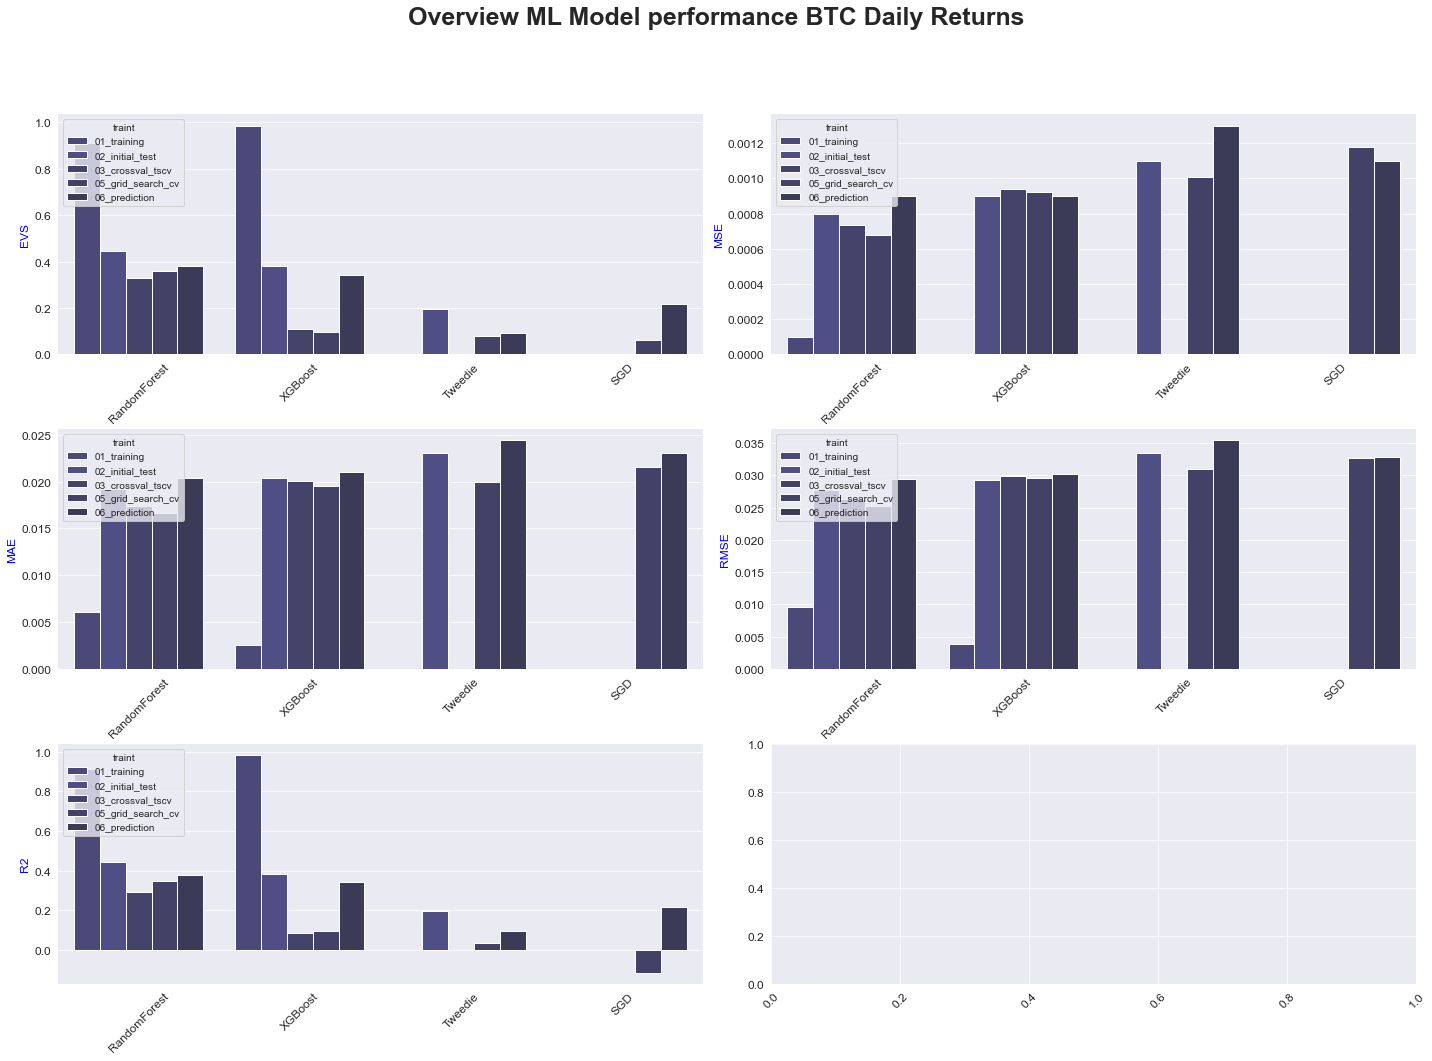

In [152]:
# Plot the final model performance
final_score_col = set(df_final_metrics.columns) - set(['traint'])

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
for feat_num, feat_name in enumerate(final_score_col):
    sns.barplot(data=df_final_metrics, x=df_final_metrics.index, y=df_final_metrics[feat_name],
                hue='traint', ax=axs[int(feat_num/2), feat_num%2], 
                palette=colors_from_values(y, "icefire"))
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_final_metrics):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Overview ML Model performance BTC Daily Returns", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

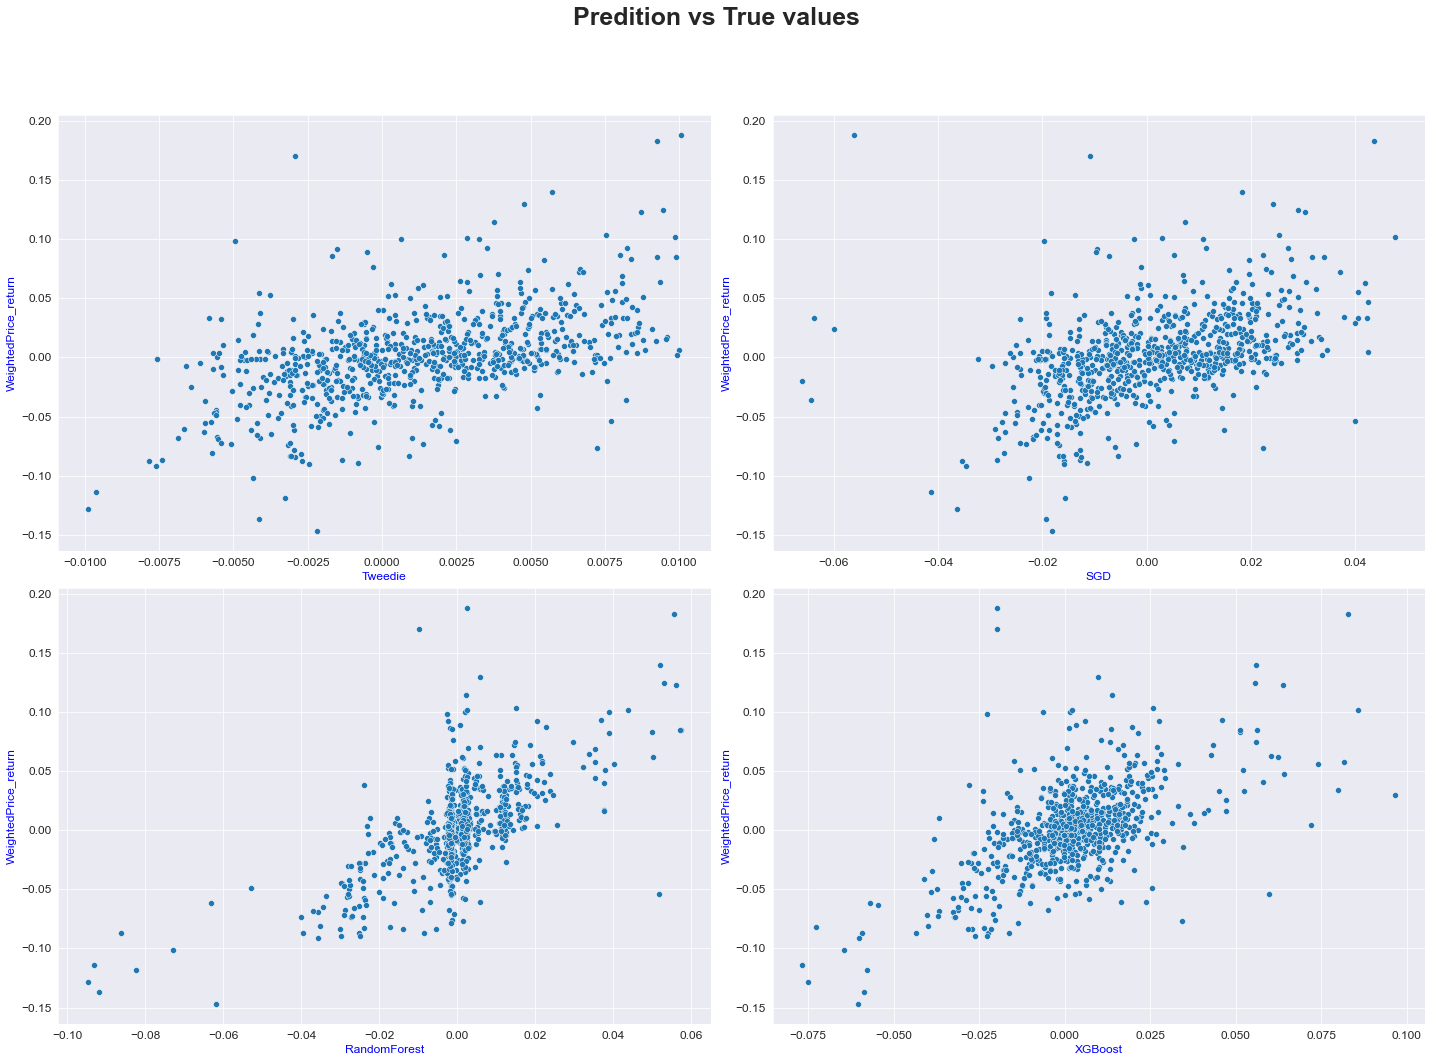

In [153]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
for num, name in enumerate(final_models):
    ax = sns.scatterplot(predictions[name], y_test_new, ax=axs[int(num/2), num%2])
    ax.set(xlabel=name)

plt.tight_layout()
plt.xlabel(name)
plt.suptitle("Predition vs True values", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()